# SVM, Transformers, Pipelines

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mglearn

from IPython.display import display

%matplotlib inline

# Целите днес: 
   - Алгоритъма за машини с поддържащи вектори (Support Vector Machines) 
   - Метода на ядрата (Kernel method) за SVM
   - Трансформатори на данни (Transformers) в sklearn  - MinMaxScaler, Standard Scaler, Imputer и други 
   - Поточни линии (pipelines) в sklearn
   - Търсене на хиперпараметри - Grid Search, Randomized Search.

# Support Vector Machines

SVM е линеен алгоритъм, който не се обяснява добре с малко математика. Ще го разгледаме на интуитивно ниво, тъй като се използва често за класификация, особено при по-сложни данни като текст и изображения. 

* Може да се използва за класификация и регресия (Ние ще разгледаме само случая за класификация).
* Бинарна класификация - опитва се да намери хипер-равнина, която да разделя двата класа.
* Оптимизира дистанцията от хипер-равнитата до точките, както и разстоянието (margin) между тях.
* Примерите по границата, определена от margin-а, се наричат "поддържащи вектори" (support vectors).
* Има нещо, наречено kernel trick, което може да се справи с нелинейни разделения.
* Може да се оправи добре със случаи, когато имаме малко данни с голяма размерност (напр. класификация на текст или картинки).
* Чувствителен към скалирането на данните.

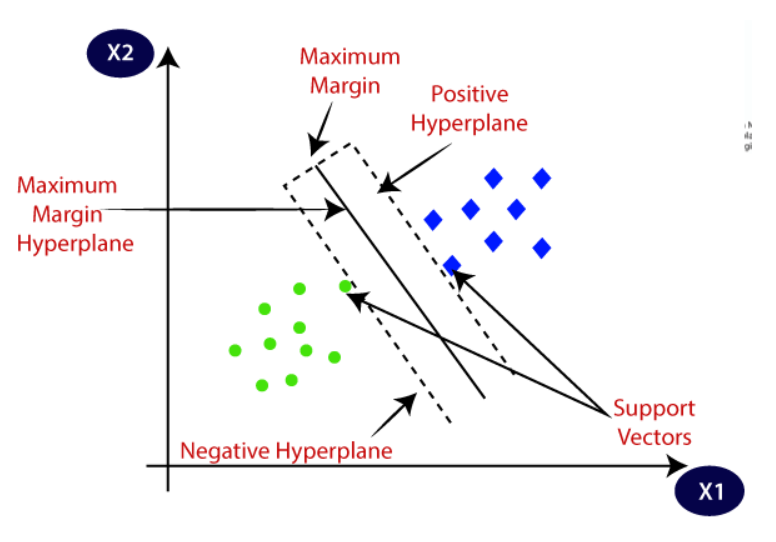

## Детайли

Eдна къса анимация, която представя визуално какво прави SVM: https://www.youtube.com/watch?v=_YPScrckx28&ab_channel=VisuallyExplained 

Ще се опитаме да създадем неформална интуиция отгоре-отгоре.

Има няколко разновидности на SVM. Ще погледнем първо линейните:

Пример за линеен SVM, намиращ хипер-равнина (права в 2D):

![](http://scikit-learn.org/stable/_images/sphx_glr_plot_separating_hyperplane_0011.png)

Алгоритъмът се опитва да оптимизира margin (разстоянието между пунктираните линии).

За класификация, може да ползвате `LinearSVC` (SVC - Support vector classification):

C:\Users\HP\anaconda3\envs\ml_course_2023\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


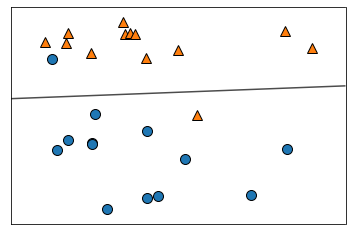

In [3]:
from sklearn.svm import LinearSVC

X, y = mglearn.datasets.make_forge()

model = LinearSVC().fit(X, y)
mglearn.plots.plot_2d_separator(model, X, fill=False, eps=0.5, alpha=.7)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y);

Има регуляризационен параметър `C`, който е обратно пропорционален на колко регуляризация искаме – ниски стойности на `C` предизвикват голяма регуляризация и обратното.

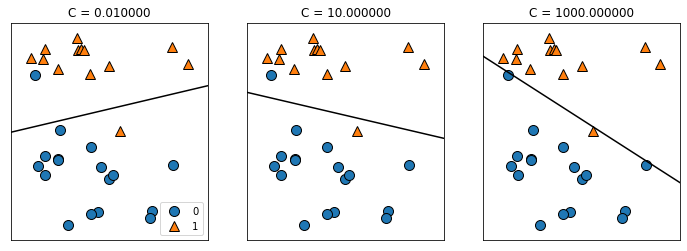

In [4]:
mglearn.plots.plot_linear_svc_regularization()

В горните диаграми се вижда, че голяма регуляризация (малко `C`) поставя акцента върху клъстерите от точки, докато ниската регуляризация (голямо `C`) се опитва да класифицира правилно всяка една точка.

## Нелинейни проблеми

Преди да видим нелинейни ядра (kernels), нека да си припомним ограниченията на линейните модели и как може да се заобиколят.

Да започнем с нелинейни данни:

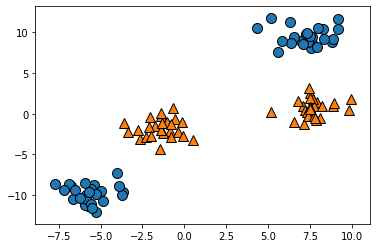

In [5]:
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y);

Да видим какво ще направи линеен модел:

C:\Users\HP\anaconda3\envs\ml_course_2023\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


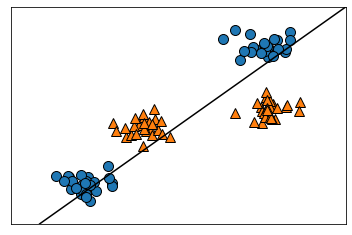

In [6]:
model = LinearSVC().fit(X, y)
mglearn.plots.plot_2d_separator(model, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y);

Как изглежда успеваемостта върху тренировъчното множество?

In [7]:
model.score(X, y)

0.67

Слабо. Да пробваме да добавим нова характеристика - квадрата на една от съществуващите. Т.е., започваме с:

In [8]:
X[:5]

array([[-1.72161036, -1.48033142],
       [-3.6573384 , -9.5482383 ],
       [ 7.0778163 ,  0.99508772],
       [-1.36579859, -0.3148625 ],
       [-2.66521206, -3.12591651]])

И добавяме $x_2^2$ на трето място:

In [9]:
X_new = np.hstack([X, X[:, 1:] ** 2])

In [10]:
X_new[:5]

array([[-1.72161036, -1.48033142,  2.19138111],
       [-3.6573384 , -9.5482383 , 91.16885455],
       [ 7.0778163 ,  0.99508772,  0.99019957],
       [-1.36579859, -0.3148625 ,  0.09913839],
       [-2.66521206, -3.12591651,  9.77135405]])

Нека да начертаем новите данни:

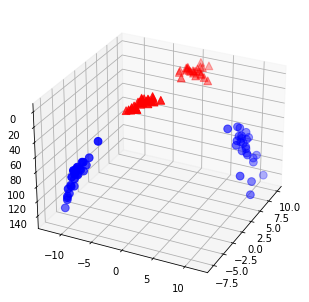

In [11]:
from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()

ax = Axes3D(figure, elev=-152, azim=-26)
mask = (y == 0)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=mglearn.cm2, s=60);

Това изглежда като разделимо с равнина. Да пробваме да я натренираме `LinearSVC`:

In [12]:
model = LinearSVC().fit(X_new, y)
model.score(X_new, y)

C:\Users\HP\anaconda3\envs\ml_course_2023\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


1.0

Явно наистина може да разделим тези точки с равнина!

Ако избухнем с малко код, може и дори да я начертаем:

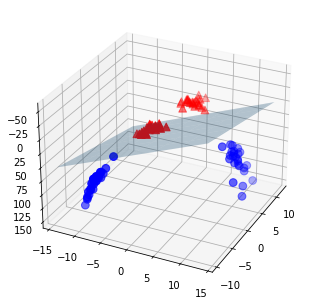

In [13]:
coef, intercept = model.coef_.ravel(), model.intercept_

figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)
XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=mglearn.cm2, s=60);

Може и да погледнем това "отгоре":

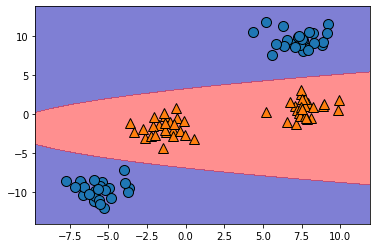

In [14]:
ZZ = YY ** 2
dec = model.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()], cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y);

## Метода на ядрата (Kernel Method) 

Накратко, функциите на ядрата (Kernel functions) проектират данните в **пространство с по-голяма размерност**, например от двуизмерно в триизмерно, и търсят хиперравнина в новото пространство. В този курс няма да навлизаме в математическите детайли. 

За целта ползвате `SVC` със `kernel='rbf'`, което е и стойността по подразбиране. RBF идва от (Gaussian) Radial Basis Function и е най-често използваната такава функция.

В [тази блог-статия](https://data-flair.training/blogs/svm-kernel-functions/) можете да намерите повече информация и примери за различни функции на ядра, които се използват в SVM.

In [15]:
from sklearn.svm import SVC

model = SVC().fit(X, y)
model.score(X, y)

1.0

Резултата е същият (намери се пълно разделение), без да се налага да познаваме какви полиномни характеристики ни трябват.

## Параметри

Има два интересни параметъра – `gamma` и `C`.

За да ги илюстрираме, ще разгледаме един друг синтетичен dataset.

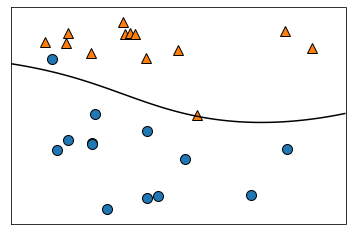

In [16]:
X, y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y);

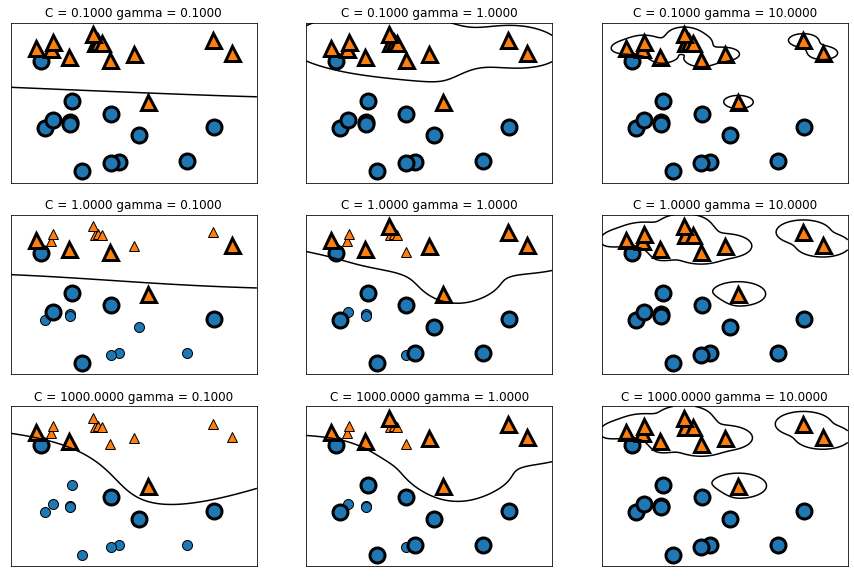

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)

Без математиката е трудно за обяснение. Най-близкото до което може да стигнем е:

* `C` е стандартния регуляризационен параметър
* `gamma` е обратно пропорционална на широчината на gaussian kernel-а (хъхъ). Висока gamma ще създава по-комплексни граници на решенията.

SVM са много чувствителни на мащаба на данните. (Защо това е така - обяснение [тук](https://stats.stackexchange.com/questions/279911/why-is-svm-sensitive-to-scaling-of-features).)


Преди да го илсютрираме, нека първо разгледаме инструментите за мащабиране.

# MinMaxScaler

Този клас позволява да промените мащаба на дадени данни. Например:

In [18]:
from sklearn.preprocessing import MinMaxScaler

data = [[100], [120], [170], [250], [300]]
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data)
scaler.transform(data)

array([[0.  ],
       [0.1 ],
       [0.35],
       [0.75],
       [1.  ]])

Може да видите параметрите, с които той оперира:

In [19]:
print("scale: {}".format(scaler.scale_))
print("min: {}".format(scaler.min_))
print("data min: {}".format(scaler.data_min_))
print("data max: {}".format(scaler.data_max_))

scale: [0.005]
min: [-0.5]
data min: [100.]
data max: [300.]


Веднъж като сте `fit`-нали на едни данни, може да ползвате `transform` за следващите.

In [20]:
scaler.transform([[150], [200], [250]])

array([[0.25],
       [0.5 ],
       [0.75]])

Обърнете внимание, че правим един път`fit` и много пъти `transform`.

`MinMaxScaler` ще скалира и данни извън първоначалния range:

In [21]:
scaler.transform([[0], [400]])

array([[-0.5],
       [ 1.5]])

Има и още един метод, `fit_transform`, който прави `fit` + `transform`:

In [22]:
data = [[100, -10], [120, 5], [170, 2]]
MinMaxScaler().fit_transform(data)

array([[0.        , 0.        ],
       [0.28571429, 1.        ],
       [1.        , 0.8       ]])

`MinMaxScaler` работи върху всички колони. Ако искате да обработите само някои, има и функция:

In [23]:
from sklearn.preprocessing import minmax_scale

minmax_scale([[1], [2], [4]])

array([[0.        ],
       [0.33333333],
       [1.        ]])

Може директно да я ползвате и за `DataFrame`:

In [24]:
frame = pd.DataFrame({
    'name': ['Edward', 'Bella', 'Jacob'],
    'age': [17, 18, 16]
}, columns=['name', 'age'])
frame

,name,age
0,Edward,17
1,Bella,18
2,Jacob,16


In [25]:
frame[['age']] = minmax_scale(frame[['age']])
frame

,name,age
0,Edward,0.5
1,Bella,1.0
2,Jacob,0.0


# StandardScaler

Подобен механизъм, който скалира до средна стойност (mean) 0 и дисперсия (variance) 1.

In [26]:
from sklearn.preprocessing import StandardScaler

data = np.array([0.0, 1.0, 3.0, 7.0, 42.0, 100.0, 2.0]).reshape(-1, 1)
StandardScaler().fit_transform(data)

array([[-0.63940499],
       [-0.61052864],
       [-0.55277593],
       [-0.43727051],
       [ 0.5734019 ],
       [ 2.24823046],
       [-0.58165228]])

Разбира се, има и функция:

In [27]:
from sklearn.preprocessing import scale

scale([0.0, 7.0, 12.0, 80.0])

array([-0.76906108, -0.55154886, -0.39618298,  1.71679293])

Всичко до тук е част от по-голяма абстракция – трансформатори.

# Transformers

В scikit-learn има класове, чиято цел е да трансформират данните. Те се характеризират със `fit` и `transform` методи:

* `fit` се вика веднъж за да "настрои" трансформацията.
* `transform` може да се вика много пъти след като вече има трансформация.
* `fit_transform` прави и двете.

В някои специални случаи, клас ще има само `fit_transform`.

**NB**: *През последните години набраха популярност един тип невронни мрежи, които също се казват Трансформатори (Transformers). Когато някой говори за Transformers в контекста на машинното самообучение, може да има предвид точно тези мрежи, а не модулът в scikit-learn. Внимавайте да не се объркате.*

Може да си имплементираме собствени трансформатори:

In [28]:
from sklearn.base import TransformerMixin

class Logarithmizer(TransformerMixin):
    def transform(self, X, *_):
        return np.log(X)

    def fit(self, *_):
        return self

In [29]:
data = [0.5, 1, 2.71828182, 7.38905609, 10]
Logarithmizer().fit_transform(data)

array([-0.69314718,  0.        ,  1.        ,  2.        ,  2.30258509])

# Imputer

[`Imputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) е трасформер, който попълва липсващите данни. Има три стратегии, контролирани с параметър `strategy`:

* `mean` – средно аритметично
* `median` – медиана
* `most_frequent` – мода

In [30]:
from sklearn.impute import SimpleImputer

values = np.array([1.0, 5.0, np.nan, 1.0, 2.0, np.nan]).reshape(-1, 1)
SimpleImputer(strategy='most_frequent').fit_transform(values)

array([[1.],
       [5.],
       [1.],
       [1.],
       [2.],
       [1.]])

# Други

* `OneHotEncoder` е трансформер
* `LabelEncoder` също
* Има и `LabelBinarizer`, който е комбинация от горните две.

# PolynomialFeatures

Трансформер, който дава полиномни фийчъри.

In [31]:
from sklearn.preprocessing import PolynomialFeatures

data = [[1, 2],
        [3, 4],
        [6, 2]]
PolynomialFeatures().fit_transform(data)

array([[ 1.,  1.,  2.,  1.,  2.,  4.],
       [ 1.,  3.,  4.,  9., 12., 16.],
       [ 1.,  6.,  2., 36., 12.,  4.]])

## Аргументи

* `degrees=2` – максимална степен на полиномите
* `include_bias=True` – константа
* `interaction_only=False` – не включва членове, където има степен, по-голяма от първа (без $x^2$, $y^3$ или $x^2y$)

# SVM и мащабиране

SVM са чувствителни на мащабиране на характеристиките. Например:

In [32]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [33]:
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

unscaled_score = SVC().fit(X_train, y_train).score(X_test, y_test)
scaled_score = SVC().fit(X_train_scaled, y_train).score(X_test_scaled, y_test)

print("Unscaled score: {:.2f}".format(unscaled_score))
print("Scaled score:   {:.2f}".format(scaled_score))

Unscaled score: 0.94
Scaled score:   0.97


Това важи и за `LinearSVC`:

In [34]:
from sklearn.svm import LinearSVC

unscaled_score = LinearSVC(random_state=42).fit(X_train, y_train).score(X_test, y_test)
scaled_score   = LinearSVC(random_state=42).fit(X_train_scaled, y_train).score(X_test_scaled, y_test)

print("Unscaled score: {:.2f}".format(unscaled_score))
print("Scaled score:   {:.2f}".format(scaled_score))

Unscaled score: 0.80
Scaled score:   0.94


C:\Users\HP\anaconda3\envs\ml_course_2023\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Pipeline

`Pipeline` (на български "поточна линия") позволява да се наредят няколко стъпки една след друга.

Пример за поточна линия за класификация: 

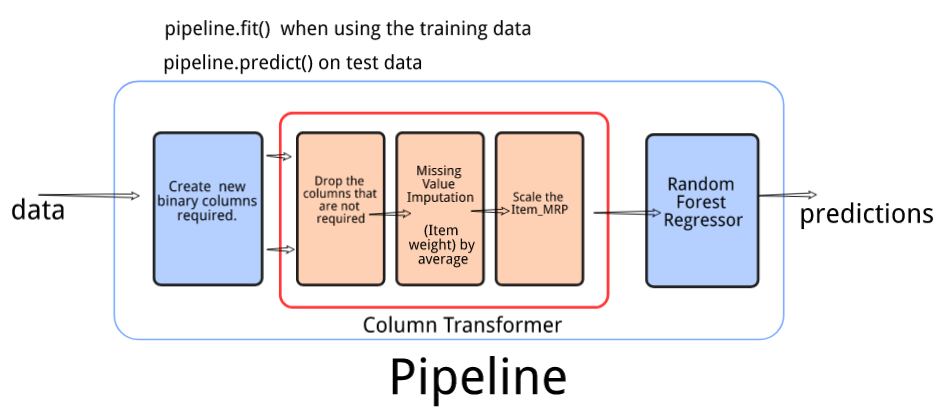

Илюстрацията е взета от [тази статия](https://www.analyticsvidhya.com/blog/2020/01/build-your-first-machine-learning-pipeline-using-scikit-learn/). В [тази статия](https://towardsdatascience.com/are-you-using-pipeline-in-scikit-learn-ac4cd85cb27f) cъщо има полезна визуализация с обяснения.

За нашия случай с SVM:

In [35]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('svm', LinearSVC()),
])

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.9440559440559441

Всяка стъпка преди последната трябва да е трансформер (да има `fit` и `transform`). Последната може да е и модел (да има `fit`, `predict` и `score`).

Имената в аргументите на pipeline са полезни понякога заради други операции, които може да прилагаме. Ще разгледаме това малко по-късно.

В по-лесния случай може да ползваме `make_pipeline`.

In [36]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(StandardScaler(), LinearSVC())

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.9440559440559441

Може да видим, че `make_pipeline` прави същото, но използва имената на класовете с малки букви:

In [37]:
pipeline

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])

# Търсене/оптимизиране на хиперпараметри     

В scikitlearn търсенето на оптимални параметри е част от модула [`model_selection`](https://scikit-learn.org/stable/modules/classes.html#hyper-parameter-optimizers).
Ще разгледаме няколко класа, които ни помагат с търсенето на оптимални хиперпараметри:

* [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) – пробва всички комбинации от параметри
* [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV) – пробва няколко семпъла от всички комбинации с параметри

Те работят добре и с pipelines. Нека видим пример:

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge

boston = load_boston()
X, y = boston.data, boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [39]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('polynomials', PolynomialFeatures()),
    ('ridge', Ridge())
])

grid = {
    'polynomials__degree': [1, 2, 3],
    'ridge__alpha': [0.001, 0.01, 1, 10, 100],
}

search = GridSearchCV(pipeline, param_grid=grid, cv=5)

Обърнете внимане подаваме параметрите при pipeline – имаме името на стъпката (напр. `polynomials`), последвано от две подчертавки (`__`), след което имаме името на параметъра (`degrees`).

In [40]:
search.fit(X_train, y_train);

In [41]:
search.best_params_

{'polynomials__degree': 2, 'ridge__alpha': 10}

Може да видим всички резултати:

In [42]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomials__degree,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003987,0.004496,0.000797,0.000399,1,0.001,"{'polynomials__degree': 1, 'ridge__alpha': 0.001}",0.762602,0.569560,0.779352,0.707744,0.790320,0.721916,0.081298,9
1,0.001985,0.000622,0.000400,0.000490,1,0.01,"{'polynomials__degree': 1, 'ridge__alpha': 0.01}",0.762617,0.569557,0.779353,0.707737,0.790333,0.721919,0.081303,8
2,0.001795,0.000746,0.000399,0.000488,1,1,"{'polynomials__degree': 1, 'ridge__alpha': 1}",0.764140,0.569216,0.779410,0.706957,0.791605,0.722266,0.081836,7
3,0.001596,0.000490,0.000199,0.000399,1,10,"{'polynomials__degree': 1, 'ridge__alpha': 10}",0.773967,0.567556,0.778461,0.700054,0.796592,0.723326,0.084591,6
4,0.001396,0.000489,0.000399,0.000488,1,100,"{'polynomials__degree': 1, 'ridge__alpha': 100}",0.781747,0.593544,0.744269,0.654180,0.766017,0.707952,0.072273,10
5,0.003984,0.001097,0.000597,0.000487,2,0.001,"{'polynomials__degree': 2, 'ridge__alpha': 0.001}",0.813194,0.639721,0.631639,0.814685,0.901616,0.760171,0.106601,4
6,0.003179,0.000386,0.000801,0.000400,2,0.01,"{'polynomials__degree': 2, 'ridge__alpha': 0.01}",0.816558,0.635223,0.628425,0.816252,0.900785,0.759448,0.108686,5
7,0.002974,0.000008,0.000804,0.000402,2,1,"{'polynomials__degree': 2, 'ridge__alpha': 1}",0.831909,0.631069,0.731638,0.867385,0.912835,0.794967,0.101366,3
8,0.003575,0.000474,0.000408,0.000499,2,10,"{'polynomials__degree': 2, 'ridge__alpha': 10}",0.866518,0.618056,0.877198,0.872335,0.909524,0.828726,0.106386,1
9,0.003575,0.000792,0.000807,0.000404,2,100,"{'polynomials__degree': 2, 'ridge__alpha': 100}",0.871595,0.623519,0.840461,0.836980,0.851609,0.804833,0.091458,2


Вероятно ще е по-добре да си ги начертаем графично:

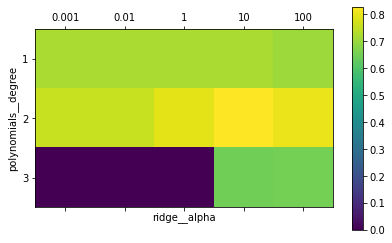

In [43]:
plt.matshow(search.cv_results_['mean_test_score'].reshape(3, -1), vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomials__degree")
plt.xticks(range(len(grid['ridge__alpha'])), grid['ridge__alpha'])
plt.yticks(range(len(grid['polynomials__degree'])), grid['polynomials__degree'])
plt.colorbar();

От графиката се вижда, че сме подбрали обхвата на параметрите добре. Ако максимума бе в ръб или ъгъл, щеше да има смисъл да погледнем други параметри.

Може да търсим и различни комбинации за даден модел – например да ползваме едни параметри при `kernel=rbf` и други при `kernel=linear`.

In [44]:
from sklearn.datasets import load_iris

iris = load_iris()

grid = [
    {'kernel': ['rbf'],
     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'kernel': ['linear'],
     'C': [0.001, 0.01, 0.1, 1, 10, 100]}
]

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

# Търсене на хиперпараметри 
search = GridSearchCV(SVC(), grid, cv=5)

# Трениране с намерените хиперпараметри
search.fit(X_train, y_train)

print(search.best_params_)
print(search.best_score_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.9731225296442687


Може дори да направим `GridSearch` в който заменяме стъпките от pipeline-а – например, може да търсим няколко комбинации от класификатори и scaler-и.

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

grid = [
    {
        'classifier': [SVC()],
        'preprocessing': [RobustScaler(), StandardScaler(), MinMaxScaler()],
        'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    {
        'classifier': [RandomForestClassifier(n_estimators=100)],
        'preprocessing': [None],
        'classifier__max_features': [2, 3, 4, 5, 6], 
        'classifier__criterion': ["gini", "entropy"]
    }
]

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

search = GridSearchCV(pipe, grid, cv=5)
search.fit(X_train, y_train)

print("Best params:\n{}\n".format(search.best_params_))
print("Best cross-validation score: {:.2f}".format(search.best_score_))

Best params:
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

Best cross-validation score: 0.99


# Особености при търсенето на хиперпараметри 

## Метод за оценка
Обърнете внимание, че за класификационни алгоритми метода за оценка по подразбиране е точност (accuracy). При силно небалансирани класове е по-добре да сменим метода с друга оценка.

In [47]:
# За iris e ok да използваме точност, тъй като класовете са перфектно балансирани
# и нямаме конкретен клас, който е по-важенно да разпознаем от останалите:
pd.Series(iris.target).value_counts(normalize=True)

2    0.333333
1    0.333333
0    0.333333
dtype: float64

In [48]:
# Не е същото при данните за рака на гърдата:
pd.Series(cancer.target).value_counts(normalize=True)

1    0.627417
0    0.372583
dtype: float64

В skicit-learn можем да променим методе за на GridSearch чрез параметъра scoring. Можем да използваме някоя от [предефинираните методи за оценка](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) или да си направим наша оценка с функцията [make_scorer](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html):

In [49]:
from sklearn.metrics import recall_score, make_scorer

recall = make_scorer(recall_score, average='weighted')

In [50]:
search = GridSearchCV(pipe, grid, cv=5, scoring=recall)
search.fit(X_train, y_train)

print("Best params:\n{}\n".format(search.best_params_))
print("Best cross-validation score: {:.2f}".format(search.best_score_))

Best params:
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

Best cross-validation score: 0.99


In [51]:
# Пълна оценка върху тестовото множество 
from sklearn.metrics import classification_report

y_pred = search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        53
           1       0.98      0.99      0.98        90

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



Тук избора на параметри при оценка точност е достатъчно добър и при смяна на оценката се запазват същите най-добри параметри, но това не винаги е така.

## Мащабиране и валидация на модела 

Нека видим още един интересен проблем. Ще се пробваме със същия dataset, но този път с cross validation.

In [62]:
from sklearn.model_selection import cross_val_score

cancer = load_breast_cancer()
X, y = scale(cancer.data), cancer.target

score = cross_val_score(LinearSVC(), X, y, cv=3)
print(score)
print(score.mean())

[0.95263158 0.96842105 0.96825397]
0.9631021999443052


Какъв е проблема в горния код?

Данните се мащабират преди train-test split, направен от крос валидацията. По този начин изтича информация от тестовия сет към тренирането. Това няма да се случи с реални данни, обаче – те ще идват с мащаб, който алгоритъма няма да знае. По-реалистично е да мащабираме само тестовите данни и да оставим възможността тестовия сет да излиза настрани.

Това може да се случи като дадем `pipeline`-а на `cross_val_score` – така той ще прави отделно мащабиране за всяко разделение, което ще е по-реален индикатор на точността.

In [63]:
X, y = cancer.data, cancer.target
pipeline = make_pipeline(StandardScaler(), LinearSVC())
score = cross_val_score(pipeline, X, y, cv=3)
print(score)
print(score.mean())

[0.94736842 0.96842105 0.96825397]
0.9613478139793928


Може да видим, че с първия fold имаме по-лош (и по-реалистичен) резултат.

Ето визуализация на грешния подход:

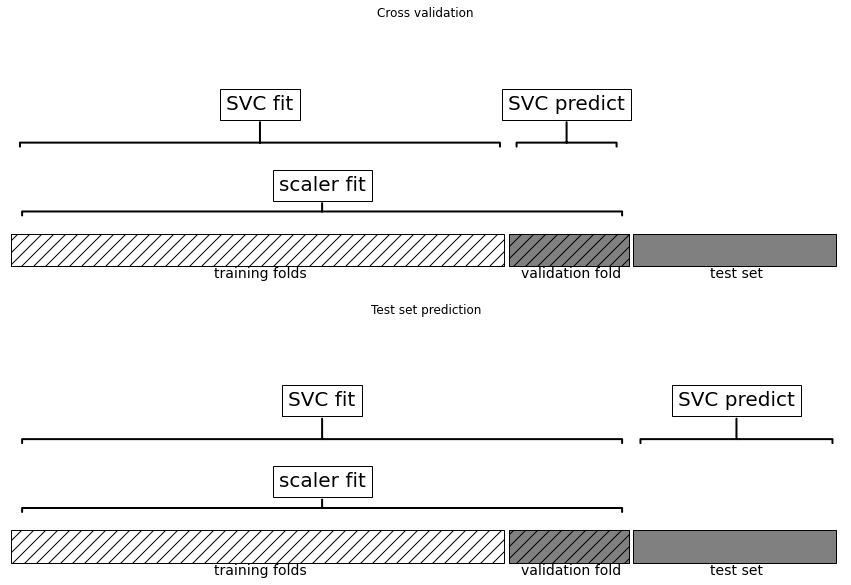

In [65]:
mglearn.plots.plot_improper_processing()

Ето как нещата трябва да изглеждат наистина:

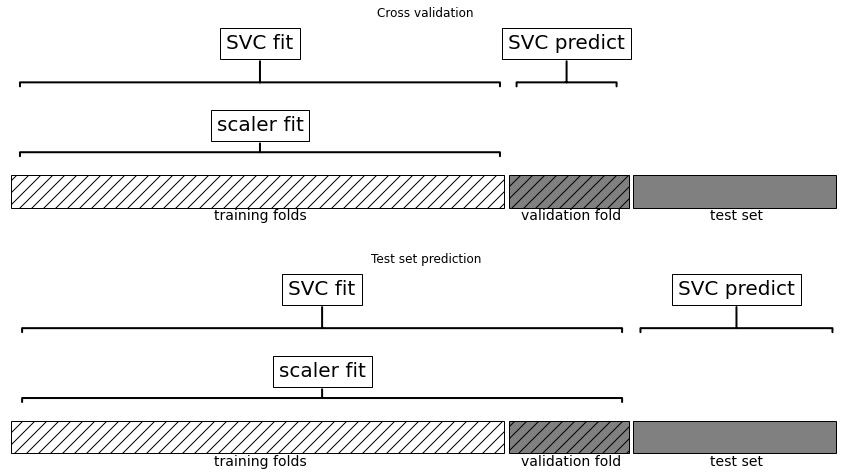

In [66]:
mglearn.plots.plot_proper_processing()

За домашно ще имате да се борите с тези проблеми - как се избират първоналачни стойности, как се мащабира и как се оценява при GridSearch. 

# Въпроси?

## Допълнитерно: FeatureUnion

Това е интересен клас, който помага за подготовката на данни. Нека видим пример – искаме да извлечем едновременно полиномни и скалирани характеристики. 

In [67]:
data = np.array([1.0, 5.0, 2.0, 7.0]).reshape(-1, 1)

In [68]:
PolynomialFeatures().fit_transform(data)

array([[ 1.,  1.,  1.],
       [ 1.,  5., 25.],
       [ 1.,  2.,  4.],
       [ 1.,  7., 49.]])

In [69]:
StandardScaler().fit_transform(data)

array([[-1.15311332],
       [ 0.52414242],
       [-0.73379939],
       [ 1.36277029]])

Бихме могли просто да конкатенираме двете матрици:

In [70]:
np.concatenate([
    PolynomialFeatures().fit_transform(data),
    StandardScaler().fit_transform(data)
], axis=1)

array([[ 1.        ,  1.        ,  1.        , -1.15311332],
       [ 1.        ,  5.        , 25.        ,  0.52414242],
       [ 1.        ,  2.        ,  4.        , -0.73379939],
       [ 1.        ,  7.        , 49.        ,  1.36277029]])

Има по-добър начин:

In [71]:
from sklearn.pipeline import FeatureUnion

union = FeatureUnion([
    ('polynomials', PolynomialFeatures()),
    ('scaled', StandardScaler()),
])
union.fit_transform(data)

array([[ 1.        ,  1.        ,  1.        , -1.15311332],
       [ 1.        ,  5.        , 25.        ,  0.52414242],
       [ 1.        ,  2.        ,  4.        , -0.73379939],
       [ 1.        ,  7.        , 49.        ,  1.36277029]])

Разбира се, аргументите на `FeatureUnion` могат да бъдат и `Pipeline` обекти. Например, бихме могли да прекараме стойностите `MinMaxScaler` преди да ги дадем на `PolynomialFeatures`:

In [72]:
union = FeatureUnion([
    ('polynomials', Pipeline([
        ('minmax', MinMaxScaler()),
        ('polynomials', PolynomialFeatures())
    ])),
    ('scaled', StandardScaler()),
])
union.fit_transform(data)

array([[ 1.        ,  0.        ,  0.        , -1.15311332],
       [ 1.        ,  0.66666667,  0.44444444,  0.52414242],
       [ 1.        ,  0.16666667,  0.02777778, -0.73379939],
       [ 1.        ,  1.        ,  1.        ,  1.36277029]])

С тези механизми може да си дефинираме нагледно preprocessing-а на данни.

### Допълнителни четива: 
- [Въведение в SVM с малко математика](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47)
- [Кога е по-подходящо да се използва логичстична регресия и кога - SVM](https://medium.com/axum-labs/logistic-regression-vs-support-vector-machines-svm-c335610a3d16)